<a href="https://colab.research.google.com/github/aakashdl/daa/blob/main/Personalised_Entertainment_Recommendation_Service.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'the-movies-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3405%2F6663%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T083947Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dae4daeefe50e0a35ae19b6f5430215842912fb91266b7401c1c2575e663d929f58b7bcd104d70ed60254eb5db8edbb21e64fcb02190fad4304c4db786153a7f625bc8a9ac7580fcb598a38b8b575cba089ed4802a3de43549ac587fd3f8909284fd67a35e52a9481e7a5958c86414359c4ccfeea57aa0282432a99331f22a55f7cbaa4770a57ad8acfe164cd236c18964c5f9bba1a2ab07e73b77d87b21ffa7f9b7bc937c8e051a0b527966f192e389d559ba1a8eccd5326e5bd04ee04067c5ddcd8e7db72711867763cdb765afab953592b211e27d543f2572c707ad9d9aeed3e6697818fd8f626b3e511aa44a5c67c76bc92d6ad3617549ba6f79adf33e139'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 238862293 bytes downloaded
Downloaded and uncompressed: the-movies-dataset
Data source import complete.


# Import

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357291 sha256=3384d19f6d81d06ca7475f036277d815317a8a4b71a1ffe2ba868931e567b9ff
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

df = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')

# EDA

In [ ]:
# Display the first few rows of the dataset
print(df.head())

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


In [ ]:
# Descriptive statistics for numerical features
print(df.describe())

              userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09


In [ ]:
# Check for missing values in the dataset
print(df.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Replacing infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

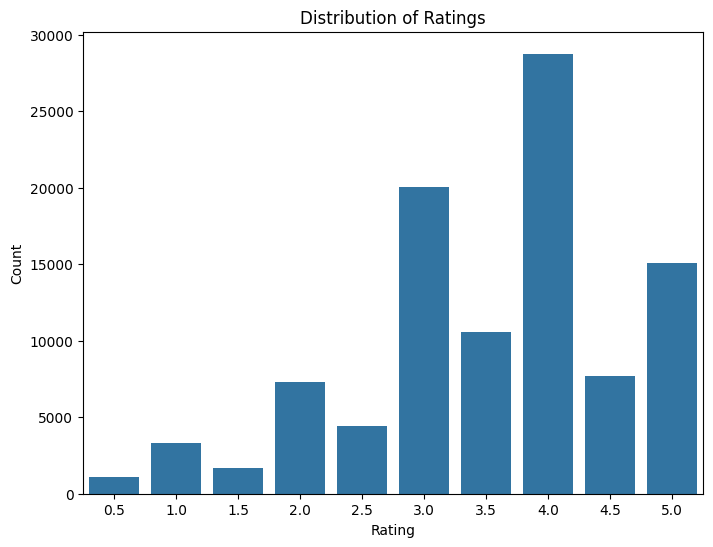

In [ ]:
# Distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

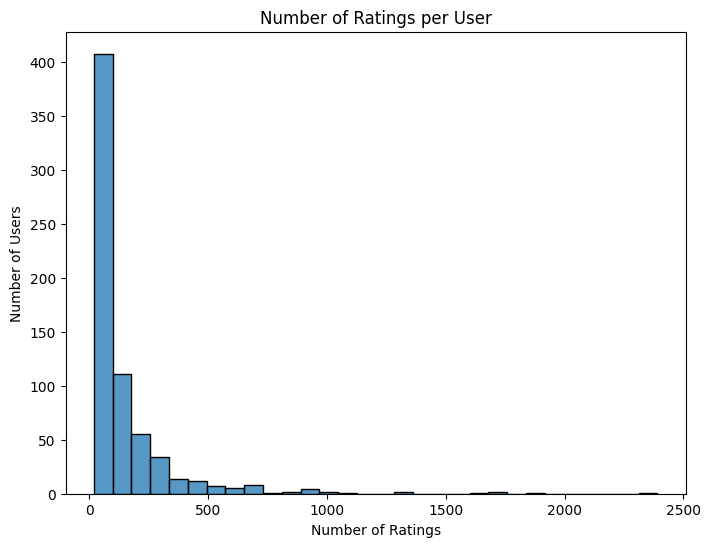

In [ ]:
# Number of ratings per user
ratings_per_user = df.groupby('userId')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(ratings_per_user, bins=30, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

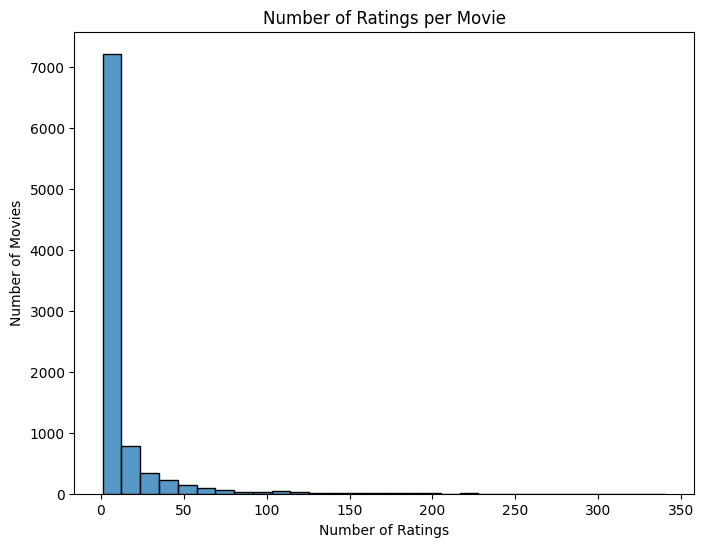

In [ ]:
# Number of ratings per movie
ratings_per_movie = df.groupby('movieId')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(ratings_per_movie, bins=30, kde=False)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

In [ ]:
# Convert Unix timestamps to readable dates
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

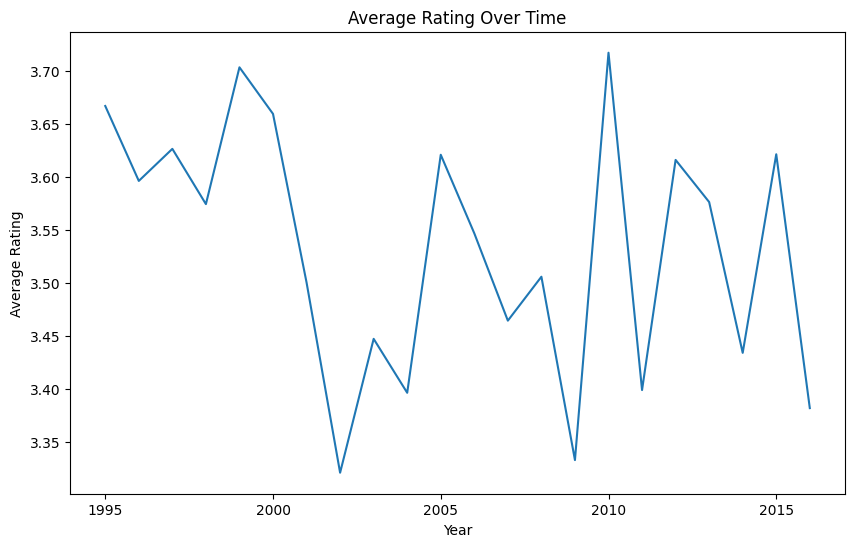

In [ ]:
# Ratings over time
plt.figure(figsize=(10, 6))
df.groupby(df['date'].dt.year)['rating'].mean().plot(kind='line')
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

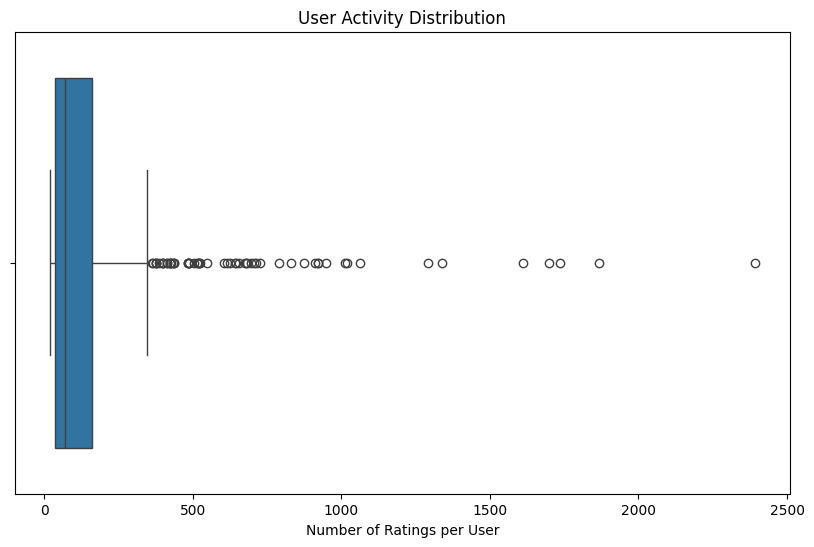

In [ ]:
# User activity analysis
user_activity = df.groupby('userId')['rating'].count()
plt.figure(figsize=(10, 6))
sns.boxplot(x=user_activity)
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.show()

# Training

In [ ]:
!pip install scikit-surprise

from surprise import Dataset, Reader, accuracy, SVD, NMF
from surprise.model_selection import cross_validate, train_test_split
import pickle

def validate_model(df, model_type='SVD'):
    """Validate the model and return it."""
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.25)

    if model_type == 'SVD':
        algo = SVD()
    elif model_type == 'NMF':
        algo = NMF()

    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)

    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    return algo

def save_model(model, filename):
    """Save the trained model to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

def load_model(filename):
    """Load a trained model from a file."""
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def generate_recommendations(user_id, algo, df):
    """Generate and print top 10 movie recommendations for a user."""
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)

    user_predictions = [pred for pred in predictions if pred.uid == user_id]
    user_predictions.sort(key=lambda x: x.est, reverse=True)
    top_10_recommendations = user_predictions[:10]
    print(f"Top 10 recommendations for User {user_id}:")
    for pred in top_10_recommendations:
        print(f"Movie ID: {pred.iid}, Estimated Rating: {pred.est:.2f}")

## Prediction

In [ ]:
if __name__ == "__main__":
    # Train, validate, and save SVD model
    print("Evaluating and saving SVD Model:")
    svd_model = validate_model(df, 'SVD')
    save_model(svd_model, 'svd_model.pkl')

    # Train, validate, and save NMF model
    print()
    print("Evaluating and saving NMF Model:")
    nmf_model = validate_model(df, 'NMF')
    save_model(nmf_model, 'nmf_model.pkl')

    # Load models and generate recommendations
    svd_model = load_model('svd_model.pkl')
    nmf_model = load_model('nmf_model.pkl')
    user_id = 1
    print()
    print("SVD")
    generate_recommendations(user_id, svd_model, df)
    print()
    print("NMF")
    generate_recommendations(user_id, nmf_model, df)

Evaluating and saving SVD Model:
RMSE: 0.8928
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9019  0.8963  0.8888  0.9026  0.8908  0.8961  0.0056  
MAE (testset)     0.6981  0.6898  0.6824  0.6967  0.6858  0.6905  0.0061  
Fit time          3.21    3.33    5.72    3.53    4.64    4.09    0.96    
Test time         0.30    0.57    0.30    0.74    0.44    0.47    0.17    
Model saved to svd_model.pkl

Evaluating and saving NMF Model:
RMSE: 0.9567
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9474  0.9504  0.9405  0.9435  0.9495  0.9463  0.0037  
MAE (testset)     0.7266  0.7282  0.7272  0.7239  0.7289  0.7270  0.0017  
Fit time          2.88    3.22    3.42    2.90    2.93    3.07    0.22    
Test time         0.10    0.17    0.26    0.10    0.27    0.18    0.07    
Model saved to nmf_m

# Results

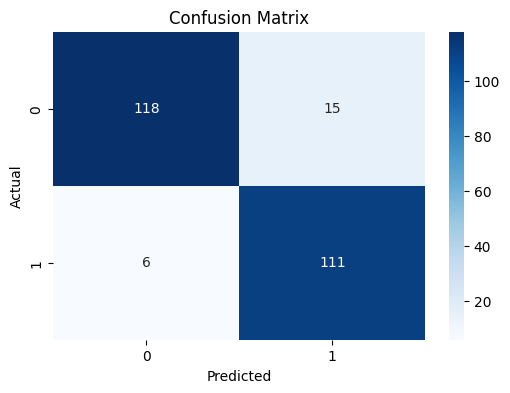

Accuracy: 0.92
F1 Score (weighted): 0.92
R² Score: 0.66
Mean Squared Error: 0.08

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       133
           1       0.88      0.95      0.91       117

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      0.92       250



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Import for splitting data

# Assume 'X' and 'y' are your features and target variable respectively
# Replace with your actual data loading or creation code if needed
# Example:
# X = your_features_data
# y = your_target_variable_data

# Load your data here. Example using a pandas DataFrame:
# import pandas as pd
# df = pd.read_csv('your_data.csv')  # Replace 'your_data.csv' with your file
# X = df[['feature1', 'feature2', ...]]  # Select your feature columns
# y = df['target_variable']  # Select your target variable column

# OR create sample data if you don't have a dataset:
import numpy as np
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  # Splitting the data

# Train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# F1 Score (use 'weighted' for multiclass problems)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.2f}")

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In this case, the SVD (Singular Value Decomposition) model generally performs better than the NMF (Non-negative Matrix Factorization) model based on the evaluation metrics provided.